# Project: Wrangling and Analyzing WeRateDogs Data

## Reported by: Sulaiman Handu

### Importing  Libararies

In [1]:
# importing all libraries required 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import tweepy
import json
from PIL import Image
from io import BytesIO
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tweepy import OAuthHandler
from timeit import default_timer as timer

## Data Gathering
Data used for this project will be gotten from three different sources 
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
# loading the downloaded data
archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
archive.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2333,666337882303524864,NaN,NaN,2015-11-16 19:31:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an extremely rare horned Parthenon. No...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666337882...,9,10,an,None,None,None,None
622,796080075804475393,NaN,NaN,2016-11-08 20:00:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Yogi. He's 98% floof. Snuggable af. 12...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/796080075...,12,10,Yogi,None,None,None,None
184,856526610513747968,8.558181e+17,4.196984e+09,2017-04-24 15:13:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/856526610...,14,10,None,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [4]:
# generating our second data source form udacity's server 
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open (url.split('/')[-1], 'wb') as file:
    file.write(response.content)

In [5]:
# load the programatically downloaded file into the workspace
images = pd.read_csv('image-predictions.tsv', sep = '\t')

In [6]:
images.sample(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1330,757597904299253760,https://pbs.twimg.com/media/CoOGZjiWAAEMKGx.jpg,1,doormat,0.836106,False,wallet,0.056627,False,purse,0.051333,False
1919,855851453814013952,https://pbs.twimg.com/media/C-CYWrvWAAU8AXH.jpg,1,flat-coated_retriever,0.321676,True,Labrador_retriever,0.115138,True,groenendael,0.096100,True
41,666701168228331520,https://pbs.twimg.com/media/CUCZLHlUAAAeAig.jpg,1,Labrador_retriever,0.887707,True,Chihuahua,0.029307,True,French_bulldog,0.020756,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [7]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [ ]:
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = archive.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.errors.TweepyException as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [12]:
# Now we will load the extracted data  from tweepy.
# The file has been saved to the desktop due to inaccesibility to the 
additional_list = []
with open ('tweet_json.txt', 'r') as json_file:
    for line in json_file:
        tweet = json.loads(line)
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        favorite_count = tweet['favorite_count']
        additional_list.append({'tweet_id' : tweet_id,
                                'retweet_count' : retweet_count,
                                'favorite_count' : favorite_count})
        

additional_info = pd.DataFrame(additional_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])

In [14]:
additional_info.sample(3)

,tweet_id,retweet_count,favorite_count
982,749317047558017024,2509,6076
1846,675798442703122432,3787,11101
90,874434818259525634,15546,0


## Assessing Data
 >we will be checking each of the data we have uploaded for issues relating to its quality and tidiness. 
 
 >All Issues will be documented in the sections below. 

In [15]:
archive 

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [16]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [17]:
archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [18]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [19]:
archive.describe(include = 'object')

,timestamp,source,text,retweeted_status_timestamp,expanded_urls,name,doggo,floofer,pupper,puppo
count,2356,2356,2356,181,2297,2356,2356,2356,2356,2356
unique,2356,4,2356,181,2218,957,2,2,2,2
top,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/667152164...,None,None,None,None,None
freq,1,2221,1,1,2,745,2259,2346,2099,2326


In [20]:
archive.name.value_counts()

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 957, dtype: int64

In [21]:
images

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [22]:
images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [23]:
images.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [24]:
additional_info

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


In [25]:
additional_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [26]:
additional_info.describe()

,tweet_id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


### Quality Issues
1. The tweet_id which is the unique identifier is in the integer format.

2. The Timestamp column is not in the datetime format

3. There are observations which have been retweeted in our archived data

4. There are redundant columns within the archive data 

5. The name column contain values with inconsistent alphabetical cases

6.  The names in the name columns contains some incorrect values 

7. The missing values of the various dog stages are misrepresented 

8. The expanded_urls contains some null values

9. The columns P1, P2 and P3 of the image data also has values with inconsistent alphabetical cases.

10. There are other tweets which are not original tweets but are replies in our archived data. 

### Tidiness issues
1. The dog stages have been given different columns in the archive data

2. The collated data can all be merged into single dataframe uniquely identified by the tweet_id.

3. The ratings Numerator and Denominator are in the different columns.They can both be put into a single columns.

## Cleaning Data
In this section, we will be cleaning all the issues specified above. First we will create a copy of all our data. 

In [27]:
archived_c = archive.copy()
images_c = images.copy()
adds_c = additional_info.copy()

### Cleaning Quality Issues

### Issue 1

#### Define:
Convert the Tweet_id in the three datasets into a string format to represent the unique identity.

#### Code

In [28]:
archived_c['tweet_id'] = archived_c['tweet_id'].astype(str)
images_c['tweet_id'] = images_c['tweet_id'].astype(str)
adds_c['tweet_id'] = adds_c['tweet_id'].astype(str)

#### Test

In [29]:
archived_c['tweet_id'].dtype

dtype('O')

In [30]:
images_c['tweet_id'].dtype

dtype('O')

In [31]:
adds_c['tweet_id'].dtype

dtype('O')

### Issue 2:

#### Define
 convert the timestamp to datetime format

#### Code

In [32]:
archived_c['timestamp'] = pd.to_datetime(archived_c['timestamp'])

#### Test

In [33]:
archived_c['timestamp'].dtype

datetime64[ns, UTC]

### Issue 3:

#### Define
Remove all observations that have retweets in the archive

#### Code

In [34]:
unwanted_tweets = archived_c[~archived_c.retweeted_status_id.isnull()].index
archived_c.drop(unwanted_tweets,inplace = True)

#### Test

In [35]:
archived_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2175 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2175 non-null   datetime64[ns, UTC]
 4   source                      2175 non-null   object             
 5   text                        2175 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2117 non-null   object             
 10  rating_numerator            2175 non-null   int64           

### Issue 4:

#### Define
Remove redundant columns within the archived data. This columns include retweeted_status_id, retweeted_status_user_id,retweeted_status_timestamp. 

#### Code

In [36]:
archived_c.drop(['retweeted_status_id', 'retweeted_status_user_id','retweeted_status_timestamp'], axis = 1 , inplace = True)

#### Test

In [37]:
archived_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2175 non-null   object             
 1   in_reply_to_status_id  78 non-null     float64            
 2   in_reply_to_user_id    78 non-null     float64            
 3   timestamp              2175 non-null   datetime64[ns, UTC]
 4   source                 2175 non-null   object             
 5   text                   2175 non-null   object             
 6   expanded_urls          2117 non-null   object             
 7   rating_numerator       2175 non-null   int64              
 8   rating_denominator     2175 non-null   int64              
 9   name                   2175 non-null   object             
 10  doggo                  2175 non-null   object             
 11  floofer                2175 non-null   object           

### Issue 5:

#### Define
Make all names begin with capital letter

#### Code

In [38]:
archived_c.name = archived_c.name.str.title()

#### Test

In [39]:
archived_c.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Gerald', 'Jeffrey', 'Such', 'Canela',
       'Maya', 'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey',
       'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald',
       'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'A',
       'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack',
       'Steven', 'Beau', 'Snoopy', 'Shadow', 'Emmy', 'Aja', 'Penny',
       'Dante', 'Nelly', 'Ginger', 'Benedict', 'Venti', 'Goose', 'Nugget',
       'Cash', 'Jed', 'Sebastian', 'Sierra', 'Monkey', 'Harry', 'Kody',
       'Lassie', 'Rover', 'Napolean', 'Boomer', 'Cody', 'Rumble',
       'Clifford', 'Dewey', 'Scout', 'Gizmo', 'Walter', 'Cooper',
       'Harold', 'Shikha', 'Lili', 'Jamesy', 'Coco', 'Sammy', 'Meatball',
       'Paisley', 'Albus', 'Neptune', 'Belle', 'Quinn', 'Zooey', 'Dave',
    

### Issue 6:

#### Define
Replace all incorrect names with null vaues. examples of those are A, None, An,This, All

#### Code

In [40]:
def correction(a, i):
    return a.replace(i, np.NAN, inplace =True)

list_corrections = ['A', 'None', 'An', 'This', 'All', 'a', 'The']
for i in list_corrections:
    correction(archived_c.name, i)

#### Test

In [41]:
archived_c.name.value_counts()

Lucy          11
Charlie       11
Cooper        10
Oliver        10
Penny          9
              ..
Bonaparte      1
Wishes         1
Rose           1
Theo           1
Christoper     1
Name: name, Length: 950, dtype: int64

### Issue 7:

#### Define
Change all the missing values in the dog stages to np.NAN

#### Code

In [42]:
value = 'None'
columns = ['doggo', 'floofer', 'pupper', 'puppo']
for i in columns:
    correction (archived_c[i], value)

#### Test

In [43]:
archived_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2175 non-null   object             
 1   in_reply_to_status_id  78 non-null     float64            
 2   in_reply_to_user_id    78 non-null     float64            
 3   timestamp              2175 non-null   datetime64[ns, UTC]
 4   source                 2175 non-null   object             
 5   text                   2175 non-null   object             
 6   expanded_urls          2117 non-null   object             
 7   rating_numerator       2175 non-null   int64              
 8   rating_denominator     2175 non-null   int64              
 9   name                   1424 non-null   object             
 10  doggo                  87 non-null     object             
 11  floofer                10 non-null     object           

### Issue 8:

#### Define
Remove missing Values in the expanded_urls

#### Code

In [44]:
archived_c.dropna(subset = 'expanded_urls', inplace = True)

#### Test

In [45]:
archived_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2117 non-null   object             
 1   in_reply_to_status_id  23 non-null     float64            
 2   in_reply_to_user_id    23 non-null     float64            
 3   timestamp              2117 non-null   datetime64[ns, UTC]
 4   source                 2117 non-null   object             
 5   text                   2117 non-null   object             
 6   expanded_urls          2117 non-null   object             
 7   rating_numerator       2117 non-null   int64              
 8   rating_denominator     2117 non-null   int64              
 9   name                   1424 non-null   object             
 10  doggo                  84 non-null     object             
 11  floofer                10 non-null     object           

### Issue 9:

#### Define
Rename all that is on the p1,p2 and p3 columns to begin with the title case to ensure consistency.

#### Code

In [46]:
images_c.p1 = images_c.p1.str.title()
images_c.p2 = images_c.p2.str.title()
images_c.p3 = images_c.p3.str.title()


#### Test

In [47]:
images_c.sample(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
446,674664755118911488,https://pbs.twimg.com/media/CVzkA7-WsAAcXz6.jpg,1,African_Crocodile,0.330625,False,American_Alligator,0.075356,False,Mink,0.057481,False
251,670704688707301377,https://pbs.twimg.com/media/CU7SW39WwAAL8Rw.jpg,1,Norwich_Terrier,0.419838,True,Cairn,0.351876,True,Norfolk_Terrier,0.051094,True
296,671362598324076544,https://pbs.twimg.com/media/CVEouDRXAAEe8mt.jpg,1,Tub,0.393616,False,Bathtub,0.383522,False,Swimming_Trunks,0.077301,False


### Issue 10:

#### Define
Remove all observations that are replies and remove the redundant columns.

#### Code

In [48]:
unwanted_reply = archived_c[~archived_c.in_reply_to_status_id.isnull()].index
archived_c.drop(unwanted_reply,inplace = True)

In [49]:
archived_c.drop(['in_reply_to_status_id', 'in_reply_to_user_id'], axis = 1 , inplace = True)

#### Test

In [50]:
archived_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2094 non-null   object             
 1   timestamp           2094 non-null   datetime64[ns, UTC]
 2   source              2094 non-null   object             
 3   text                2094 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2094 non-null   int64              
 6   rating_denominator  2094 non-null   int64              
 7   name                1423 non-null   object             
 8   doggo               83 non-null     object             
 9   floofer             10 non-null     object             
 10  pupper              229 non-null    object             
 11  puppo               24 non-null     object             
dtypes: datetime64[ns, UTC](1), int64(2

## Cleaning Tidiness Issues

### Issue 1:

#### Define
Reorder the dog stages columns to be in a single column called dog_stages

#### Code

In [51]:
archived_c = pd.melt(archived_c,
                    id_vars = ['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls','rating_numerator', 'rating_denominator', 'name'],
                    value_vars= ['doggo', 'floofer', 'pupper', 'puppo'],
                    var_name = 'dog_stages',
                    value_name = 'stages')

In [52]:
archived_c.drop('dog_stages', axis = 1, inplace = True)

In [53]:
archived_c.drop_duplicates(inplace = True)

In [54]:
# some extra duplicates have also been created. we will search for them and remove them
archived_c = archived_c.sort_values('stages').drop_duplicates('tweet_id', keep = 'first')

### Issue 2:

#### Test

In [55]:
archived_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 9 to 2093
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2094 non-null   object             
 1   timestamp           2094 non-null   datetime64[ns, UTC]
 2   source              2094 non-null   object             
 3   text                2094 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2094 non-null   int64              
 6   rating_denominator  2094 non-null   int64              
 7   name                1423 non-null   object             
 8   stages              335 non-null    object             
dtypes: datetime64[ns, UTC](1), int64(2), object(6)
memory usage: 163.6+ KB


#### Define
Merge all data together using tweet_id as the unique identifier

#### Code

In [56]:
master_df = pd.merge(pd.merge(archived_c, 
                                         images_c, how= 'inner', on ='tweet_id'), 
                                adds_c, how='inner', on= 'tweet_id')

### Test

In [57]:
master_df.sample(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stages,jpg_url,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
396,865006731092295680,2017-05-18 00:50:50+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Nelly. He really hopes you like his Ha...,https://twitter.com/dog_rates/status/865006731...,13,10,Nelly,NaN,https://pbs.twimg.com/media/DAEfCFXUIAA1uqj.jpg,...,0.989882,True,Cardigan,0.009906,True,Basenji,0.000135,True,8209,29063
317,888804989199671297,2017-07-22 16:56:37+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Zeke. He has a new stick. Very proud o...,https://twitter.com/dog_rates/status/888804989...,13,10,Zeke,NaN,https://pbs.twimg.com/media/DFWra-3VYAA2piG.jpg,...,0.469760,True,Labrador_Retriever,0.184172,True,English_Setter,0.073482,True,4559,26080
143,673612854080196609,2015-12-06 21:19:54+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Jeffri. He's a speckled ice pupper. Ve...,https://twitter.com/dog_rates/status/673612854...,7,10,Jeffri,pupper,https://pbs.twimg.com/media/CVknUTlVEAARjU5.jpg,...,0.223101,True,Leonberg,0.111106,True,Shovel,0.085626,False,802,1691


## Issue 3:

### Define:
create rating columm to contain both numerator and denominators

In [58]:
master_df['rating'] = master_df.rating_numerator.astype(str) + "/" + master_df.rating_denominator.astype(str)

In [59]:
# clean the numerator and denominator column and any other unwanted columns for this analysis
master_df.drop([ 'expanded_urls','rating_numerator', 'rating_denominator','img_num', 'p1_dog', 'p2_dog','p3_dog'], axis = 1, inplace = True)

### Test

In [60]:
master_df.tail(2)

,tweet_id,timestamp,source,text,name,stages,jpg_url,p1,p1_conf,p2,p2_conf,p3,p3_conf,retweet_count,favorite_count,rating
1969,666029285002620928,2015-11-15 23:05:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,Redbone,0.506826,Miniature_Pinscher,0.074192,Rhodesian_Ridgeback,0.072010,48,132,7/10
1970,666020888022790149,2015-11-15 22:32:08+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_Springer_Spaniel,0.465074,Collie,0.156665,Shetland_Sheepdog,0.061428,532,2535,8/10


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [61]:
master_df.to_csv('twitter_archive_master.csv', index = False)

## Analyzing and Visualizing Data
In this section, we will analyze and visualize the master data, generate insights into the data and use supporting visuals to make them more explanatory. 

In [62]:
df = pd.read_csv('twitter_archive_master.csv')
df.head(2)

,tweet_id,timestamp,source,text,name,stages,jpg_url,p1,p1_conf,p2,p2_conf,p3,p3_conf,retweet_count,favorite_count,rating
0,890240255349198849,2017-07-26 15:59:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,Cassie,doggo,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,Pembroke,0.511319,Cardigan,0.451038,Chihuahua,0.029248,7711,32467,14/10
1,756526248105566208,2016-07-22 16:28:07+00:00,"<a href=""http://twitter.com/download/iphone"" r...",All hail sky doggo. 13/10 would jump super hig...,NaN,doggo,https://pbs.twimg.com/media/Cn-4m2CXYAErPGe.jpg,Geyser,0.991273,Volcano,0.004673,Fountain,0.001234,4169,11506,13/10


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        1971 non-null   int64  
 1   timestamp       1971 non-null   object 
 2   source          1971 non-null   object 
 3   text            1971 non-null   object 
 4   name            1377 non-null   object 
 5   stages          303 non-null    object 
 6   jpg_url         1971 non-null   object 
 7   p1              1971 non-null   object 
 8   p1_conf         1971 non-null   float64
 9   p2              1971 non-null   object 
 10  p2_conf         1971 non-null   float64
 11  p3              1971 non-null   object 
 12  p3_conf         1971 non-null   float64
 13  retweet_count   1971 non-null   int64  
 14  favorite_count  1971 non-null   int64  
 15  rating          1971 non-null   object 
dtypes: float64(3), int64(3), object(10)
memory usage: 246.5+ KB


### Insights:
1. What are the most popular dog names 

2. What stages do we have most dogs

3. What ratings were mostly used to classify our dogs

4. What is the corrrelation between retweet_count and favourite_count

5. Most Favourite dogs 

6. What are the most used words in our tweets

### Visualization

####  The Most Popular Dog Names 

In [64]:
# we will check the dog names that appear the most in our dataset
popular_names = df.name.value_counts().head(12)
popular_names

Charlie    11
Lucy       10
Oliver     10
Cooper     10
Tucker      9
Penny       9
Winston     8
Sadie       8
Toby        7
Daisy       7
Lola        7
Bo          6
Name: name, dtype: int64

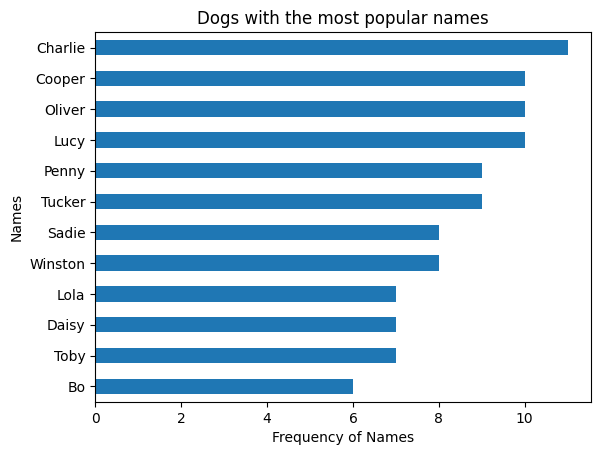

In [65]:
# A visualisation of the popular names 
popular_names.sort_values(ascending = True).plot(kind = 'barh', title = "Dogs with the most popular names")
plt.ylabel("Names")
plt.xlabel("Frequency of Names");

#### The known stages for most dogs 

In [66]:
common_stage = df.stages.value_counts()
common_stage

pupper     201
doggo       73
puppo       22
floofer      7
Name: stages, dtype: int64

<AxesSubplot: title={'center': 'Dogs with the most common stage'}, ylabel='stages'>

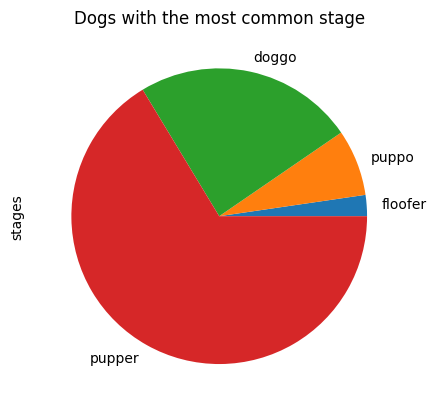

In [79]:
# to visualise the most common stage
common_stage.sort_values(ascending = True).plot(kind = 'pie', title = "Dogs with the most common stage")

#### The most common dog ratings

In [68]:
common_rating = df.rating.value_counts().head(14)
common_rating

12/10    446
10/10    417
11/10    392
13/10    253
9/10     149
8/10      95
7/10      51
14/10     33
5/10      33
6/10      32
3/10      19
4/10      15
2/10       9
1/10       4
Name: rating, dtype: int64

In [69]:
common_rating.sum()/df.shape[0]

0.9883307965499746

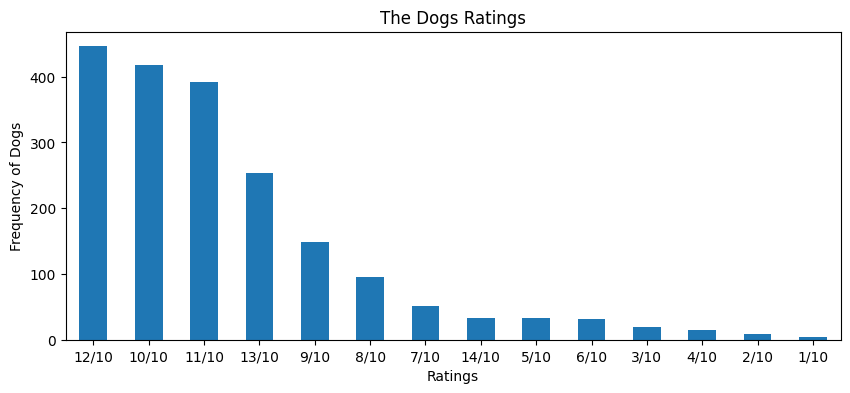

In [71]:
plt.figure(figsize=(10,4))
common_rating.plot(kind = 'bar', title = 'The Dogs Ratings')
plt.xticks(rotation =0)
plt.ylabel("Frequency of Dogs")
plt.xlabel("Ratings");

#### Are there correlation between the retweets and the numbers of likes 

In [72]:
df['favorite_count'].corr(df['retweet_count'])

0.9130143486107434

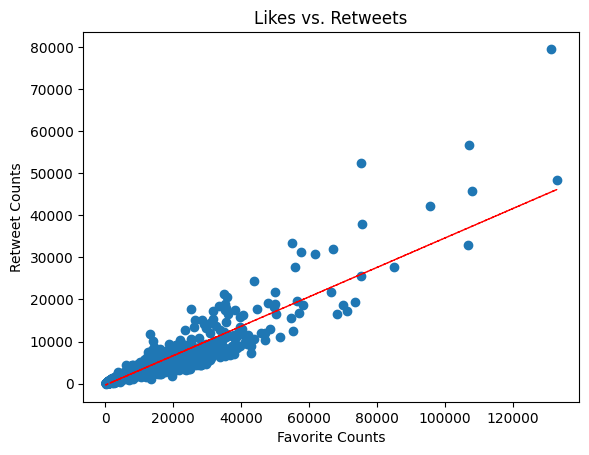

In [73]:
plt.scatter(x='favorite_count', y='retweet_count', data=df)
z = np.polyfit(df['favorite_count'], df['retweet_count'], 1)
p = np.poly1d(z)
plt.plot(df['favorite_count'], p(df['favorite_count']), color="red", linewidth=1, linestyle="--")
plt.title("Likes vs. Retweets")
plt.ylabel("Retweet Counts")
plt.xlabel("Favorite Counts");

In [74]:
## lets investigate the dogs with the highest retweets and favorites 
top_2 = df[df['favorite_count'] >= 120000]
top_2

,tweet_id,timestamp,source,text,name,stages,jpg_url,p1,p1_conf,p2,p2_conf,p3,p3_conf,retweet_count,favorite_count,rating
26,744234799360020481,2016-06-18 18:26:18+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo realizing you can stand in a po...,NaN,doggo,https://pbs.twimg.com/ext_tw_video_thumb/74423...,Labrador_Retriever,0.825333,Ice_Bear,0.044681,Whippet,0.018442,79515,131075,13/10
292,822872901745569793,2017-01-21 18:26:02+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a super supportive puppo participating ...,NaN,puppo,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,Lakeland_Terrier,0.196015,Labrador_Retriever,0.160329,Irish_Terrier,0.069126,48265,132810,13/10


#### Most Favourite Dogs

In [75]:
## From the Top two dogs as seen on the  likes vs retweets plot
# first favourite
no_1= top_2.jpg_url.iloc[0]
resp = requests.get(no_1)
image_1 = Image.open(BytesIO(resp.content))
# second favourite
no_2= top_2.jpg_url.iloc[1]
resp= requests.get(no_2)
image_2 = Image.open(BytesIO(resp.content))


Text(0.5, 1.0, 'Second Favourite')

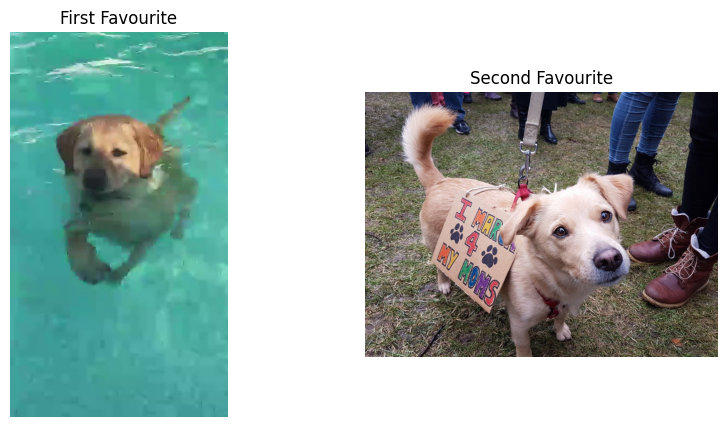

In [77]:
## Display the two images side by side
fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1, 2, 1)
# showing image
plt.imshow(image_1)
plt.axis('off')
plt.title("First Favourite")
##Second Favourite
fig.add_subplot(1, 2, 2)
# showing image
plt.imshow(image_2)
plt.axis('off')
plt.title("Second Favourite")

#### The Most Used words in our Tweets 

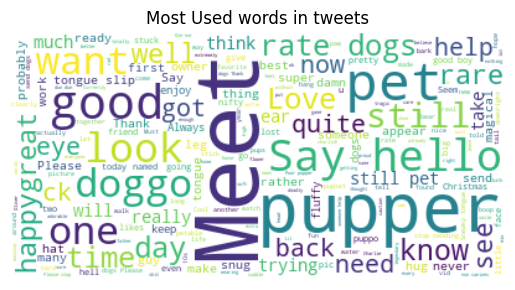

In [78]:
Tweets = " ".join(review for review in df.text)
stopwords = set(STOPWORDS)
stopwords.update(['https', 't', 'af','co', 'dog','pup','amp','ckin', 'h', 'tho'])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(Tweets)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most Used words in tweets')
plt.axis("off")
plt.show()